In [32]:
import matplotlib as plt
import pandas as pd
import time

from itertools import combinations
from scipy.interpolate import UnivariateSpline

import sys
sys.path.append('/Users/trevor/git/datascience-utils')
sys.path.append('/Users/trevor/git/tpeschek')

from time_of_day.data.generic_queries import hc_quarter_hour_tz_adjusted, hc_quarter_hour_unadjusted
from time_of_day.data.model_storage import load_parameters, store_parameters, get_optimized_set
from time_of_day.process import TrackBest, add_spline, eval_combinations, compute_bidmods
from time_of_day.problem_space import possible_time_segments

pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', None)


START_DATE = '20200912'
END_DATE = '20201013'

PRODUCT = 'MEDICARE'




INFO:root:query: SELECT date_part(DOW, user_ts)::INT AS dayofweek, date_part(... executed in 0.23 seconds
INFO:root:query: SELECT date_part(DOW, utc_ts)::INT AS dayofweek, date_part(H... executed in 0.25 seconds
/Users/trevor/venvs/py38/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:title={'center':'Revenue Per Session, User Timezone Adjusted via IP'}, xlabel='dayofweek,hourofday'>

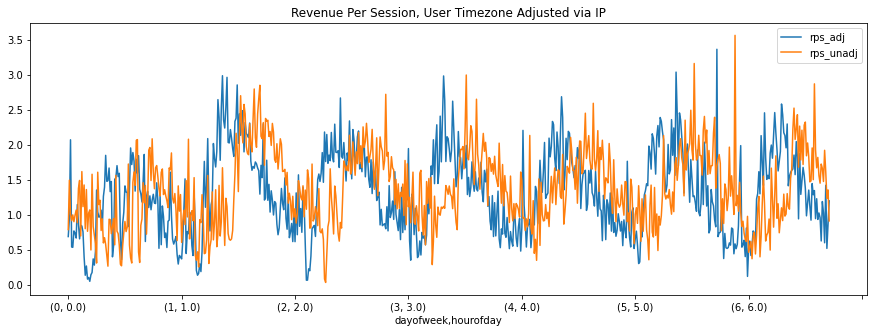

In [33]:
df_tz_adj = hc_quarter_hour_tz_adjusted(start_date=START_DATE, end_date=END_DATE, product=PRODUCT)
df_unadj = hc_quarter_hour_unadjusted(start_date=START_DATE, end_date=END_DATE, product=PRODUCT)

df_tz_adj.rename(columns={'rps': 'rps_adj'}).merge(
    df_unadj.rename(columns={'rps': 'rps_unadj'}), 
    left_index=True, 
    right_index=True
)[['rps_adj', 'rps_unadj']].plot(figsize=(15,5), title='Revenue Per Session, User Timezone Adjusted via IP')

In [34]:
df_tz_adj.head()

days_samplesize  sessions  conversions  conv_rate  \
dayofweek hourofday                                                      
0         0.0000                   5        33           22     0.1309   
          0.2500                   5        26           14     0.1076   
          0.5000                   5        24           24     0.1951   
          0.7500                   5        20            9     0.0865   
          1.0000                   5        20            9     0.0900   

                     avg_conv_value    rps  int_ix  
dayofweek hourofday                                 
0         0.0000             5.2791 0.6913       0  
          0.2500             8.8200 0.9498       1  
          0.5000            10.6170 2.0716       2  
          0.7500             6.2711 0.5427       3  
          1.0000             5.9800 0.5382       4

<AxesSubplot:xlabel='int_ix', ylabel='rps'>

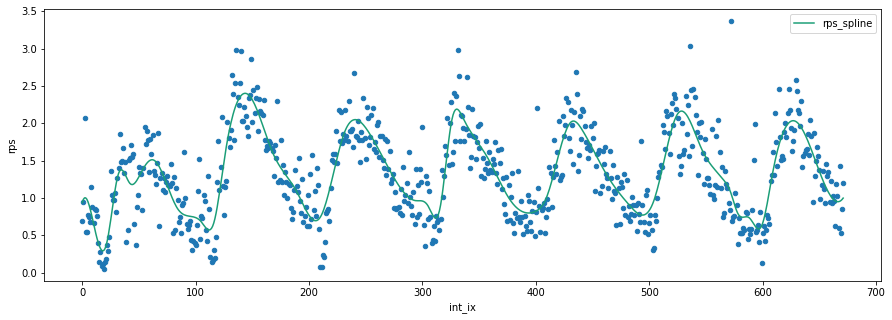

In [43]:
RPS_SPLINE_K = 3
RPS_SPLINE_S = 75

df_tz_adj = add_spline(df_tz_adj, index_col='int_ix', smooth_col='rps', spline_k=RPS_SPLINE_K, spline_s=RPS_SPLINE_S)

ax = df_tz_adj[['rps']].reset_index().plot.scatter(x='int_ix', y='rps')
df_tz_adj[['rps_spline']].plot(ax=ax, figsize=(15,5), colormap='Dark2')

<AxesSubplot:xlabel='int_ix', ylabel='sessions'>

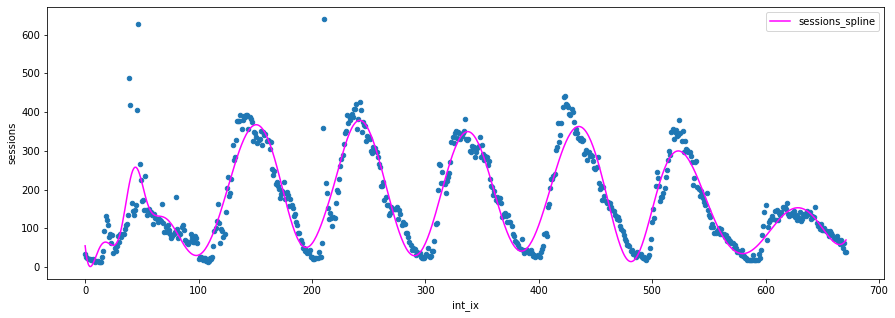

In [48]:
SESSIONS_SPLINE_K = 5
SESSIONS_SPLINE_S = 1550000

df_tz_adj = add_spline(df_tz_adj, index_col='int_ix', smooth_col='sessions', spline_k=SESSIONS_SPLINE_K, spline_s=SESSIONS_SPLINE_S)

ax = df_tz_adj[['sessions']].reset_index().plot.scatter(x='int_ix', y='sessions')
df_tz_adj[['sessions_spline']].plot(ax=ax, figsize=(15,5), colormap='spring')

<AxesSubplot:xlabel='int_ix'>

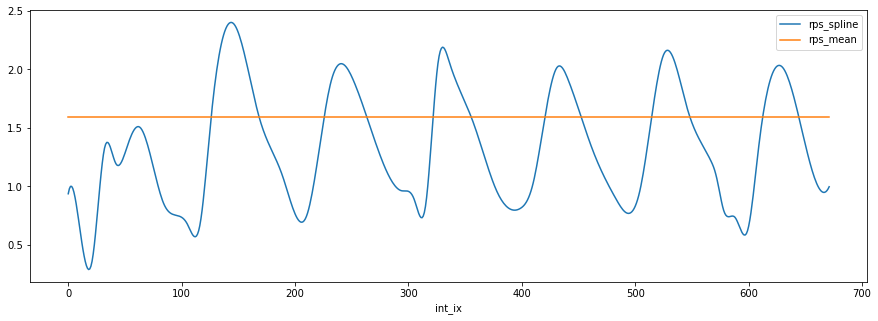

In [49]:
df_tz_adj['rps_mean'] = (df_tz_adj['sessions_spline'] * df_tz_adj['rps_spline']).sum() / df_tz_adj['sessions_spline'].sum()

df_tz_adj[['rps_spline', 'rps_mean']].plot(figsize=(15,5))

<AxesSubplot:xlabel='int_ix'>

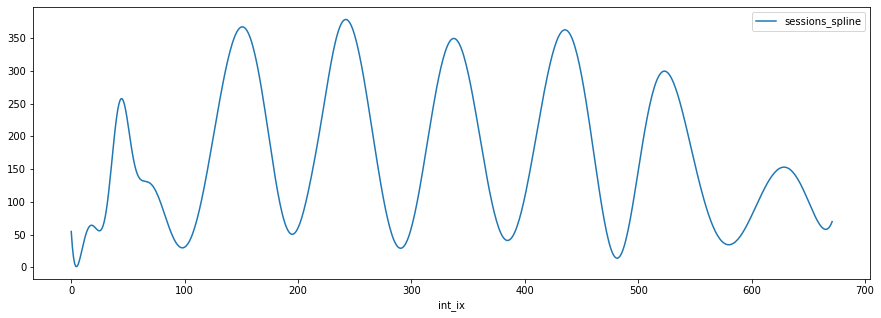

In [50]:
df_tz_adj[['sessions_spline']].plot(figsize=(15,5))

In [51]:
HOUR_RESOLUTION = 1.0
SEGMENTS_PER_DAY = 7

problem_space = possible_time_segments(hour_resolution=HOUR_RESOLUTION, periods=SEGMENTS_PER_DAY)

preview_rows = 10
for n in range(preview_rows):
    print(next(problem_space))

[(0.0, 1.0), (1.0, 2.0), (2.0, 3.0), (3.0, 4.0), (4.0, 5.0), (5.0, 6.0), (6.0, 24.0)]
[(0.0, 1.0), (1.0, 2.0), (2.0, 3.0), (3.0, 4.0), (4.0, 5.0), (5.0, 7.0), (7.0, 24.0)]
[(0.0, 1.0), (1.0, 2.0), (2.0, 3.0), (3.0, 4.0), (4.0, 5.0), (5.0, 8.0), (8.0, 24.0)]
[(0.0, 1.0), (1.0, 2.0), (2.0, 3.0), (3.0, 4.0), (4.0, 5.0), (5.0, 9.0), (9.0, 24.0)]
[(0.0, 1.0), (1.0, 2.0), (2.0, 3.0), (3.0, 4.0), (4.0, 5.0), (5.0, 10.0), (10.0, 24.0)]
[(0.0, 1.0), (1.0, 2.0), (2.0, 3.0), (3.0, 4.0), (4.0, 5.0), (5.0, 11.0), (11.0, 24.0)]
[(0.0, 1.0), (1.0, 2.0), (2.0, 3.0), (3.0, 4.0), (4.0, 5.0), (5.0, 12.0), (12.0, 24.0)]
[(0.0, 1.0), (1.0, 2.0), (2.0, 3.0), (3.0, 4.0), (4.0, 5.0), (5.0, 13.0), (13.0, 24.0)]
[(0.0, 1.0), (1.0, 2.0), (2.0, 3.0), (3.0, 4.0), (4.0, 5.0), (5.0, 14.0), (14.0, 24.0)]
[(0.0, 1.0), (1.0, 2.0), (2.0, 3.0), (3.0, 4.0), (4.0, 5.0), (5.0, 15.0), (15.0, 24.0)]


In [52]:

model_run_id = int(time.time())

store_parameters(
    model_run_epoch=model_run_id,
    start_date=START_DATE,
    end_date=END_DATE,
    hour_resolution=HOUR_RESOLUTION,
    segments_per_day=SEGMENTS_PER_DAY,
    rps_spline_k=RPS_SPLINE_K, 
    rps_spline_s=RPS_SPLINE_S, 
    sessions_spline_k=SESSIONS_SPLINE_K,
    sessions_spline_s=SESSIONS_SPLINE_S
)

print('Parameters stored under model id: ', model_run_id)


INFO:root:query: CREATE TABLE IF NOT EXISTS data_science.time_of_day_model_ru... executed in 0.29 seconds
INFO:root:query: INSERT INTO data_science.time_of_day_model_runs VALUES ( 160... executed in 0.43 seconds


Parameters stored under model id:  1602702206


In [77]:
health_run_id = 1602699901
medicare_run_id = 1602702206

health_config = load_parameters(model_run_epoch=health_run_id)
health_set = get_optimized_set(model_run_epoch=health_run_id)
health_df = hc_quarter_hour_tz_adjusted(
    start_date=health_config['start_date'],
    end_date=health_config['end_date'],
    product='HEALTH'
)

medicare_config = load_parameters(model_run_epoch=medicare_run_id)
medicare_set = get_optimized_set(model_run_epoch=medicare_run_id)
medicare_df = hc_quarter_hour_tz_adjusted(
    start_date=medicare_config['start_date'],
    end_date=medicare_config['end_date'],
    product='MEDICARE'
)


INFO:root:query: SELECT model_run_epoch, start_date, end_date, hour_resolutio... executed in 0.11 seconds
INFO:root:query: SELECT optimized_intervals FROM data_science.time_of_day_mod... executed in 0.11 seconds
INFO:root:query: SELECT date_part(DOW, user_ts)::INT AS dayofweek, date_part(... executed in 0.23 seconds
INFO:root:query: SELECT model_run_epoch, start_date, end_date, hour_resolutio... executed in 0.11 seconds
INFO:root:query: SELECT optimized_intervals FROM data_science.time_of_day_mod... executed in 0.11 seconds
INFO:root:query: SELECT date_part(DOW, user_ts)::INT AS dayofweek, date_part(... executed in 0.23 seconds


In [78]:
health_df = add_spline(health_df, index_col='int_ix', smooth_col='sessions', 
    spline_k=health_config['sessions_spline_k'], 
    spline_s=health_config['sessions_spline_s']
)
health_df = add_spline(health_df, index_col='int_ix', smooth_col='rps', 
    spline_k=health_config['rps_spline_k'], 
    spline_s=health_config['rps_spline_s']
)
health_df['rps_mean'] = (health_df['sessions_spline'] * health_df['rps_spline']).sum() / health_df['sessions_spline'].sum()
health_df = health_df.reset_index()
health_df = health_df[['int_ix', 'dayofweek', 'hourofday', 'sessions_spline', 'rps_spline', 'rps_mean']]
health_bidmods, health_df = compute_bidmods(health_set, health_df)



medicare_df = add_spline(medicare_df, index_col='int_ix', smooth_col='sessions', 
    spline_k=medicare_config['sessions_spline_k'], 
    spline_s=medicare_config['sessions_spline_s']
)
medicare_df = add_spline(medicare_df, index_col='int_ix', smooth_col='rps', 
    spline_k=medicare_config['rps_spline_k'], 
    spline_s=medicare_config['rps_spline_s']
)
medicare_df['rps_mean'] = (medicare_df['sessions_spline'] * medicare_df['rps_spline']).sum() / medicare_df['sessions_spline'].sum()
medicare_df = medicare_df.reset_index()
medicare_df = medicare_df[['int_ix', 'dayofweek', 'hourofday', 'sessions_spline', 'rps_spline', 'rps_mean']]
medicare_bidmods, medicare_df = compute_bidmods(medicare_set, medicare_df)


In [79]:
health_df.head()

,int_ix,dayofweek,hourofday,sessions_spline,rps_spline,rps_mean,baseline,weight,interval_mean,modifier,weekday
0,0,0,0.0000,162.2679,0.2530,0.8930,1.0000,0.2792,0.2049,0.2295,sunday
1,1,0,0.2500,154.9556,0.2800,0.8930,1.0000,0.2666,0.2049,0.2295,sunday
2,2,0,0.5000,148.5369,0.2975,0.8930,1.0000,0.2556,0.2049,0.2295,sunday
3,3,0,0.7500,142.9848,0.3067,0.8930,1.0000,0.2460,0.2049,0.2295,sunday
4,4,0,1.0000,138.2716,0.3083,0.8930,1.0000,0.2379,0.2049,0.2295,sunday


In [80]:
l_df = health_df.set_index('int_ix')[['modifier', 'rps_spline', 'baseline']]
l_df = l_df.rename(columns={'modifier': 'modifier_health', 'rps_spline': 'rps_health'})

r_df = medicare_df.set_index('int_ix')[['modifier', 'rps_spline']]
r_df = r_df.rename(columns={'modifier': 'modifier_medicare', 'rps_spline': 'rps_medicare'})

m_df = l_df.merge(r_df, how='inner', left_index=True, right_index=True)
m_df.head()

,modifier_health,rps_health,baseline,modifier_medicare,rps_medicare
int_ix,,,,,
0,0.2295,0.2530,1.0000,0.4473,1.2237
1,0.2295,0.2800,1.0000,0.4473,1.1093
2,0.2295,0.2975,1.0000,0.4473,1.0066
3,0.2295,0.3067,1.0000,0.4473,0.9153
4,0.2295,0.3083,1.0000,0.4473,0.8347


<AxesSubplot:xlabel='int_ix'>

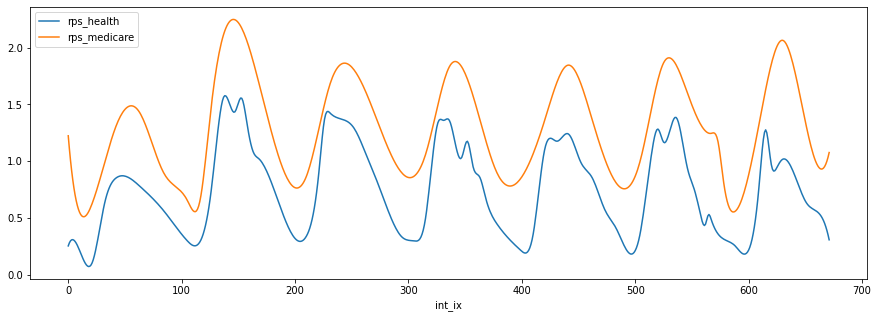

In [81]:
m_df[['rps_health', 'rps_medicare']].plot(figsize=(15,5))

<AxesSubplot:xlabel='int_ix'>

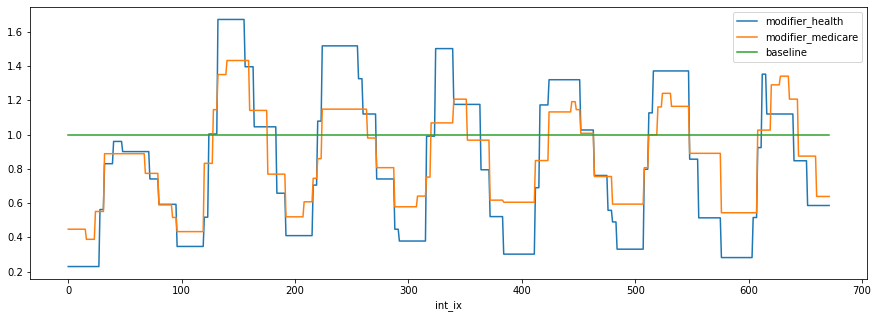

In [82]:
m_df[['modifier_health', 'modifier_medicare', 'baseline']].plot(figsize=(15,5))

In [83]:
additional_scales = [0.75, 0.5, 0.25]


def df_generate_scaling(df, col, scales):

    for scale in scales:
        postfix = '_' + str(scale).replace('.', '').lstrip('0')
        df[col + postfix] = ((df[col] - 1.0) * scale) + 1.0
    
    return df

<AxesSubplot:xlabel='int_ix'>

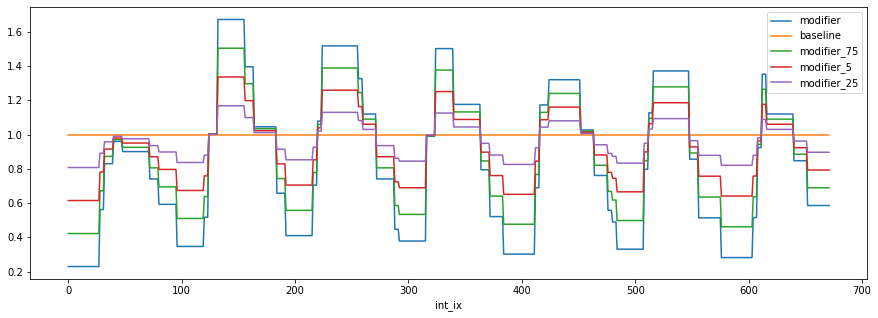

In [84]:
health_scales_df = df_generate_scaling(
    df=health_df[['int_ix', 'modifier', 'baseline']].copy(),
    col='modifier',
    scales=additional_scales
)

health_scales_df.set_index('int_ix').plot(figsize=(15,5))

In [91]:
def process_and_scale(modifiers_ls, scales):
    
    df = pd.DataFrame(modifiers_ls, columns=['day', 'start_at', 'end_before', 'modifier'])
    
    for scale in scales:
        postfix = '_' + str(scale).replace('.', '').lstrip('0')
        df['modifier' + postfix] = ((df['modifier'] - 1.0) * scale) + 1.0
        
    return df


In [92]:
health_mods = process_and_scale(health_bidmods, additional_scales).round(2)

health_mods.to_csv('/Users/trevor/health_bidmods.csv', float_format='%.2f')

In [93]:
medicare_mods = process_and_scale(medicare_bidmods, additional_scales).round(2)

medicare_mods.to_csv('/Users/trevor/medicare_bidmods.csv', float_format='%.2f')

<AxesSubplot:xlabel='int_ix'>

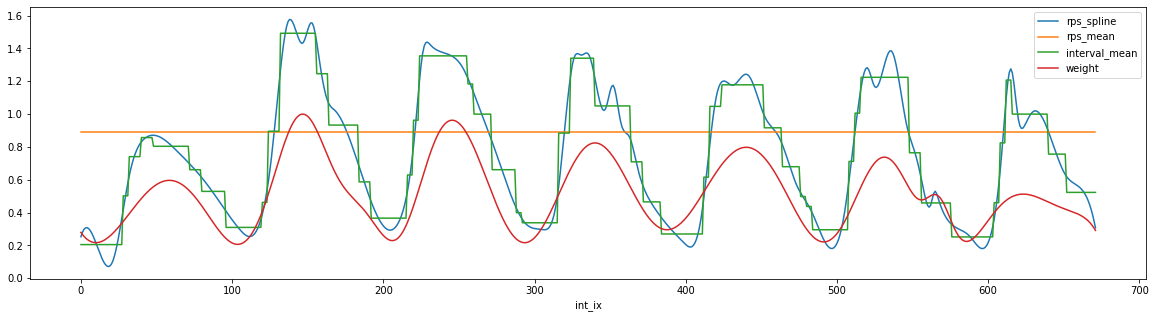

In [99]:
health_df.set_index('int_ix')[['rps_spline', 'rps_mean', 'interval_mean', 'weight']].plot(figsize=(20,5))